## Decision Tree

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt   
from matplotlib.legend_handler import HandlerLine2D

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the CSV file.
data = pd.read_csv('CTG.csv', skiprows=1)

In [3]:
# Select the relevant numerical columns.
selected_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
                 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
                 'Median', 'Variance', 'Tendency', 'NSP']

In [4]:
data = data[selected_cols].dropna()


In [5]:
data.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [6]:
# Shuffle the dataset.
data_shuffled = data.sample(frac=1.0, random_state=0)

In [7]:
# Split into input part X and output part Y.
X = data_shuffled.drop('NSP', axis=1)


In [8]:
# Map the diagnosis code to a human-readable label.
def to_label(y):
    return [None, 'normal', 'suspect', 'pathologic'][(int(y))]


In [9]:
Y = data_shuffled['NSP'].apply(to_label)

In [10]:
# Partition the data into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

# Dummy Classifier

In [11]:
dummy = DummyClassifier(strategy='most_frequent')

In [12]:
cross_val_score(dummy, Xtrain, Ytrain).mean()

0.7805882352941176

By cross-validating the dummy classifier on the training data's different fold, we get a mean accuracy of <b>78% </b> in predicting the classification of the fetal states into the three class Normal, Suspicious, or Pathological.

In this section we are going to expirement few different types of classifiers for the aim of finding the classifier with the highest accuracy in the differentiation task of the fetal states classification.

# Tree-based classifiers

We firstly start by experimenting the Decision Tree classifier of sklearn on our training data

## Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier

skDT = DecisionTreeClassifier()
cross_val_score(skDT, Xtrain, Ytrain).mean()

0.9241176470588235

As we can see, the DT classifier obtained a cross-validation accuracy of an average of <b>92.4%</b> on the different folds of the training data when being called with the default values of its parameters, so we proceed by tuning the classifier.

### DecisionTree hyperparameter (max_depth) tuning through a graph

plot to verify the determine the max_depth hyperparameter

In [14]:
import matplotlib.pyplot as plt   
from matplotlib.legend_handler import HandlerLine2D

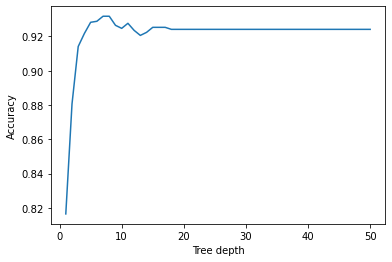

In [15]:
import numpy as np

max_depths = np.linspace(1, 50, 50, endpoint=True)

train_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth,random_state=0)
    accuracyTemp = cross_val_score(dt, Xtrain, Ytrain).mean()
    train_results.append(accuracyTemp)
    
line2 = plt.plot(max_depths, train_results, label='Train accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

As we can see in the graph, the maximum depth maximizes the accuracy of the DT classifier when its maximimum depth is between 8-10 approximately and decreases to stay constant after the depth of 18. (This cv accuracy values are guaranteed when the max_depth is varying while the other parameters are held with their default values)

### DecisionTree hyperparameter tuning using sklearn gridsearch

Moving on, to tune the hyperparameters max_depth and criterion with different combinations of their values in order to find the best combination that maximizes the model's csv average accuracy, we use sklearn's gridsearch meathod

In [16]:
dTgridTuned = DecisionTreeClassifier(random_state=0)
parameter_space = {'max_depth': [3,5,6,7,8,9,10,40,70,100],
                'criterion': ['gini','entropy']}
DtTuned = GridSearchCV(dTgridTuned, parameter_space, n_jobs=-1, cv=5)
DtTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 6, 7, 8, 9, 10, 40, 70, 100]})

In [17]:
DtTuned.best_params_

{'criterion': 'entropy', 'max_depth': 40}

In [18]:
DtTuned.best_score_

0.9341176470588234

By running searching the search space of the different combination of both parameters, the gridsearch found that when <b> criterion = 'entropy'</b> and <b> max_depth = 40</b>, the cv accuracy is maximized to <b>93.4% </b> in predicting the status of the fetus.

## Random Forest

Afterwards, we moved forward to experiment the Random Forest classifier model, since the Decision tree classifier performed well compared to the baseline dummy classifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(random_state=0)
cross_val_score(RF, Xtrain, Ytrain).mean()

0.9429411764705883

As we can see, the RF classifier obtained a cross-validation accuracy of an average of <b>94%</b> on the different folds of the training data when being called with the default values of its parameters, so we proceed by tuning the classifier.

### n_estimators hyperparameter tuning with graph

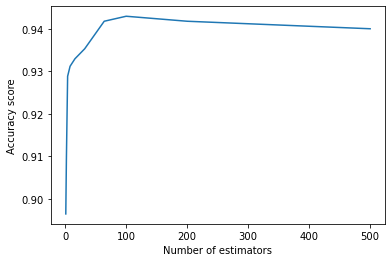

In [20]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200,500]
train_results = []
for estimator in n_estimators:
    RF = RandomForestClassifier(n_estimators=estimator,random_state=0)
    accuracyTemp = cross_val_score(RF, Xtrain, Ytrain).mean()
    train_results.append(accuracyTemp)
    
plt.plot(n_estimators, train_results, label='Train accuracy')

plt.ylabel('Accuracy score')
plt.xlabel('Number of estimators')
plt.show()

As we can see in the graph above, the number of estimator trees that maximizes the accuracy of the RF classifier when its n_estimators is 120 estimators approximately and the accuracy starts in decreasing slightly as the number of estimators increases. (This cv accuracy values are guaranteed when the n_estimators is varying while the other parameters are held with their default values)

### Random Forest Classifier hyperparameter tuning with gridsearch

In [21]:
RfCgridTuned = RandomForestClassifier()
parameter_space = {'max_depth': [0,2,3,5,10,40,70,100],
                 'criterion': ['gini', 'entropy'],
                   'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200,500]}
RFCTuned = GridSearchCV(RfCgridTuned, parameter_space, n_jobs=-1, cv=5)
RFCTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
 

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
 

  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 287, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbo

  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 287, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbo

  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
 

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
 

  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 903, in fit
    super().fit(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 287, in fit
    raise ValueError("max_depth must be greater than zero. ")
ValueError: max_depth must be greater than zero. 

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbo

  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Applications/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 2, 3, 5, 10, 40, 70, 100],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200,
                                          500]})

In [22]:
RFCTuned.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 32}

In [23]:
RFCTuned.best_score_

0.9447058823529412

As we can see, for the purpose of reaching a higher accuracy in the cross-validation phase, we tune the hyperparameter <i>maxdepth, criterion, and n_estimators </i> of the model using a gridsearch to find the the parameters that maximized the model's cv accuracy are <b>criterion = 'entropy', max_depth = 10, and n_estimators = 32</b> as by applying those parameters values on the model, the model acieved a cv accuracy of <b>94.4%</b>

## Gradient Boosting Classifier

We continue to repeat the steps carried out on the models above for more models

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(random_state=0)
cross_val_score(GBC, Xtrain, Ytrain).mean()

0.9494117647058824

We experiment the Gradient Boosting Classifier model on the training data, and we find that with the model's default parameters, the model achived an average cross validation accuracy on the different folds of the training set of approximately <b> 95% </b>.

### max_depth hyperparameter tuning through a graph

plot to verify the determine the max_depth hyperparameter

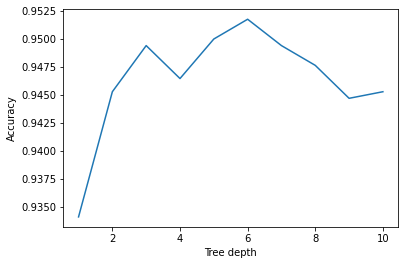

In [25]:
max_depths = np.linspace(1, 10, 10, endpoint=True)

train_results = []

for max_depth in max_depths:
    GBC = GradientBoostingClassifier(max_depth=max_depth,random_state=0)
    accuracyTemp = cross_val_score(GBC, Xtrain, Ytrain).mean()
    train_results.append(accuracyTemp)
    
plt.plot(max_depths, train_results, label='Train accuracy')
    
# plt.ylim(bottom=0)
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

By tuning the model's hyperparameter <b> max_depth</b>, we can see from the graph aove that the value of <b> max_depth</b> that maximizes the models average cross validation accuracy on the different fold of the training set is <b> max_depth = 6</b> that results in an avergae cv accuracy of aprroximately <b>95.2%</b>

### GradientBoosting Classifier hyperparameter tuning with gridsearch

In [26]:
GBCgridTuned = GradientBoostingClassifier()
parameter_space = {'loss' : ['deviance', 'exponential'],
                'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
                'n_estimators' : [4, 8, 16, 64, 100]
                ,'learning_rate': [0.001,0.01,1]
                  }
GBCTuned = GridSearchCV(GBCgridTuned, parameter_space, n_jobs=-1, cv=5)
GBCTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: Exponenti

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 448, in fit
    self._check_params()
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 249, in _check_params
    self.loss_ = loss_class(self.n_classes_)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb_losses.py", line 775, in __init__
    raise ValueError("{0:s} requires 2 classes; got {1:d} class(es)"
ValueError: ExponentialLoss requires 2 classes; got 3 class(es)

  warnings.warn("Estimato

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Tracebac

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'ms

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error', 'mse',
                                       'mae'],
                         'learning_rate': [0.001, 0.01, 1],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [4, 8, 16, 64, 100]})

In [27]:
GBCTuned.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 1,
 'loss': 'deviance',
 'n_estimators': 100}

In [28]:
GBCTuned.best_score_

0.9429411764705883

furthermore, we tuned the differen hyperparameters of the model <b> loss, criterion, n_estimators, and learning_rate </b> using a gridsearch to get a best score of the different combination of the gridsearch of <b> 94.2%</b>, which is less than the average cross validation accuracy obtained by max_depth=6 with the rest of the parameters set to their defaults, therefore for the GradientBoosting Classifier model we use the graphically tuned version with <b>max_depth = 6</b>

In [29]:
GBCFinal = GradientBoostingClassifier(max_depth = 6)
cross_val_score(GBCFinal, Xtrain, Ytrain).mean()

0.95

# Linear Classifiers

Afterwards, we moved forward to try a set of different linear classifiers

## Perceptron Classifier

In [30]:
from sklearn.linear_model import Perceptron

In [31]:
perceptron = Perceptron()
cross_val_score(perceptron, Xtrain, Ytrain).mean()

0.825294117647059

For perceptron linear model, we obtaind an average cross validation accuracy on the different folds of the training set of <b>82.5%</b>

### Hyperparameter tuning with sklearn grid search

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV

we tune the perceptron model based on the learning rate (alpha), penalty, and number of epochs as they are the most parameters having effect on the model's accuracy

In [33]:
perceptron = Perceptron(random_state=0)
parameter_space = {'alpha': [0.00001,0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
                   'penalty': ['l2', 'l1', 'elasticnet'],
                'max_iter': [3,5, 10, 15, 20, 50]}
perceptronTuned = GridSearchCV(perceptron, parameter_space, n_jobs=-1, cv=5)
perceptronTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum num

GridSearchCV(cv=5, estimator=Perceptron(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.0003, 0.001, 0.003, 0.01,
                                   0.03, 0.1, 0.3],
                         'max_iter': [3, 5, 10, 15, 20, 50],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [34]:
perceptronTuned.best_params_

{'alpha': 0.001, 'max_iter': 50, 'penalty': 'l1'}

In [35]:
perceptronTuned.best_score_

0.8505882352941176

By tuning the hyperparameters of the perceptron model using a grid search, the average cv accuracy on the different fold of the training set is raised to <b>85%</b>

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
LogR = LogisticRegression()
cross_val_score(LogR, Xtrain, Ytrain).mean()

0.8741176470588234

For the Logistic Regression model, we obtaind an average cross validation accuracy on the different folds of the training set of <b>87.4%</b>

### Tuning logistic regression

In [38]:
LogRgridTuned = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1, 10, 100,1000], 'penalty': ['l1', 'l2']}

LogRTuned = GridSearchCV(LogRgridTuned, param_grid)

LogRTuned.fit(Xtrain, Ytrain);

In [39]:
LogRTuned.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [40]:
LogRTuned.best_score_

0.8811764705882353

By tuning the logistic regression model on the <b> Inverse of regularization strength (C) and the norm of the penalty </b>, we find that the hyperparameter combination that maximizes the average cv accuracy to approximately <b> 88%</b> is <b> C = 0.01 and penalty = L2</b>

## Linear Support Vector Classifier

In [41]:
from sklearn.svm import LinearSVC

In [42]:
lsvc = LinearSVC(random_state=0)
cross_val_score(lsvc, Xtrain, Ytrain).mean()

0.8452941176470589

For the Linear Support Vector Classifier model, we obtaind an average cross validation accuracy on the different folds of the training set of <b> 84.5%</b>

### Linear SVC hyperparameter tuning with gridsearch

In [43]:
lsvcGridTuned = LinearSVC()

param_grid = {'C': [0.01, 0.1, 1, 10, 100,1000], 'penalty': ['l1', 'l2'],'loss':['hinge', 'squared_hinge']}

lsvcTuned = GridSearchCV(lsvcGridTuned, param_grid)

lsvcTuned.fit(Xtrain, Ytrain);

In [44]:
lsvcTuned.best_params_

{'C': 100, 'loss': 'hinge', 'penalty': 'l2'}

In [45]:
lsvcTuned.best_score_

0.8788235294117646

By tuning the Linear SVC model on the <b> the Regularization parameter (C), the loss function, and the norm of the penalty </b>, we find that the hyperparameter combination that maximizes the average cv accuracy to approximately <b> 88%</b> is <b> C = 100, loss = hinge,  and penalty = L2</b>

# Neural network classifier

Moreover, we experiment the neural network based model Multilayer perceptron from sklearn

## MLP Classifier

In [46]:
from sklearn.neural_network import MLPClassifier

In [47]:
NNC = MLPClassifier(random_state=0)
cross_val_score(NNC, Xtrain, Ytrain).mean()

0.8847058823529412

For the MLP Classifier model, we obtaind an average cross validation accuracy on the different folds of the training set of <b>88.5%</b>

### Hyperparameter tuning for NN

In [53]:
mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(1000,),(5000,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['invscaling', 'adaptive'],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu', 'logistic'],
                         'alpha': [0.0001],
                         'hidden_layer_sizes': [(1000,), (5000,)],
                         'learning_rate': ['invscaling', 'adaptive'],
                         'solver': ['adam']})

In [54]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (1000,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [55]:
clf.best_score_

0.9123529411764707

By tuning the MLP classifier model on the parameter <b> number of hidden layers, activation function, solver, learning rate, and type of learning rate </b>, we obtained that the values of the parameters specified above resulted in an increase in the average cv accuracy to approximately <b> 91.2%</b>

# Final evaluation

Moving forward, we choose the highest models scoring average cross validation accuracies to predict with them the testing set and evaluate their prediction accuracy.

### Cross Validation Accuracies

In [67]:
# Dummy Classifier
print("The cross-validation accuarcy of the Dummy Classifier is :"+str(round(cross_val_score(dummy, Xtrain, Ytrain).mean(),3)))
# Decision Tree
print("The cross-validation accuarcy of the Decision Tree Classifier is :"+str(round(DtTuned.best_score_,3)))
# Random Forset
print("The cross-validation accuarcy of the Random Forest Classifier is :"+str(round(RFCTuned.best_score_,3)))
#Gradient Boosting
print("The cross-validation accuarcy of the Gradient Boosting Classifier is :"+str(round(cross_val_score(GBCFinal, Xtrain, Ytrain).mean(),3)))
#Perceptron
print("The cross-validation accuarcy of the Perceptron Classifier is :"+str(round(perceptronTuned.best_score_,3)))
# Logistic Regression
print("The cross-validation accuarcy of the Logistic Regression Classifier is :"+str(round(perceptronTuned.best_score_,3)))
# LinearSVC
print("The cross-validation accuarcy of the Linear support vector classifier is :"+str(round(lsvcTuned.best_score_,3)))
# Multi layer perceptron (MLP) Neural Network Classifier
print("The cross-validation accuarcy of the Multi layer perceptron (MLP) Neural Network Classifier is :"+str(round(clf.best_score_,3)))


The cross-validation accuarcy of the Dummy Classifier is :0.781
The cross-validation accuarcy of the Decision Tree Classifier is :0.934
The cross-validation accuarcy of the Random Forest Classifier is :0.945
The cross-validation accuarcy of the Gradient Boosting Classifier is :0.949
The cross-validation accuarcy of the Perceptron Classifier is :0.851
The cross-validation accuarcy of the Logistic Regression Classifier is :0.851
The cross-validation accuarcy of the Linear support vector classifier is :0.879
The cross-validation accuarcy of the Multi layer perceptron (MLP) Neural Network Classifier is :0.912


We can see that the Gradient Boosting Classifier performed the best within the used classifiers in classification of the <b>  fetal states </b> into the three class <i>Normal<i>, <i>Suspicious<i>, or <i>Pathological<i> with a average validation accuracy of <b>95%</b> with a difference of 0.4% average cross-validation accuracy than the validation accuracy of the Random Forest Tree classifier, and 1.5% difference than the Decision Tree classifier, we proceed forward to test the prediction accuracy of those 3 models on the testing set

## Test data prediction

###  Gradient Boosting Classifier predicitions and accuracy on the test set

In [68]:
GBCFinal.fit(Xtrain, Ytrain)
Yguess = GBCFinal.predict(Xtest)
print('First 10 tuples of test-predicted data (Actual value, predicted value)')
cpt=0
for i in zip(Ytest,Yguess):
    cpt+=1
    if cpt <11:
        print(i)

First 10 tuples of test-predicted data (Actual value, predicted value)
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('suspect', 'suspect')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')


In [69]:
print('Testing accuracy of Gradient Boosting: '+str(round(accuracy_score(Ytest, Yguess),3)))

Testing accuracy of Gradient Boosting: 0.934


###  Random Forest Classifier predicitions and accuracy on the test set

In [62]:
Yguess = RFCTuned.predict(Xtest)
print('First tuples 10 of test-predicted data (Actual value, predicted value)')
cpt=0
for i in zip(Ytest,Yguess):
    cpt+=1
    if cpt <11:
        print(i)

First tuples 10 of test-predicted data (Actual value, predicted value)
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('suspect', 'suspect')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')


In [64]:
print('Testing accuracy of Random Forest: '+str(round( accuracy_score(Ytest, Yguess),3)))

Testing accuracy of Random Forest: 0.937


###  Decision Tree classifier predicitions and accuracy on the test set

In [65]:
Yguess = DtTuned.predict(Xtest)
print('First 10 tuples of test-predicted data (Actual value, predicted value)')
cpt=0
for i in zip(Ytest,Yguess):
    cpt+=1
    if cpt <11:
        print(i)

First 10 tuples of test-predicted data (Actual value, predicted value)
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('suspect', 'suspect')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')
('normal', 'normal')


In [66]:
print('Testing accuracy of Decision Tree: '+str(round( accuracy_score(Ytest, Yguess),3)))

Testing accuracy of Decision Tree: 0.913


From the classifiers above, we can see that the highest scoring classifier is the Random Forest Classifier with a prediction accuracy of 93.7% accuracy on the test set, and a gap of 0.3% between the cv accuracy and the testing accuracy, therefore we know that the classifier is not overfitting the training data, and can be used for future predictions. Recall that a gridsearch was used to tune the hyperparameters of this model to find the values of the hyperparameters as <b>'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 32</b>

# Task 2

In [12]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [13]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id
        

In [14]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, ClassifierMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [15]:
from collections import Counter

class TreeClassifier(DecisionTree, ClassifierMixin):

    def __init__(self, max_depth=10, criterion='maj_sum'):
        super().__init__(max_depth)
        self.criterion = criterion
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'maj_sum':
            self.criterion_function = majority_sum_scorer
        elif self.criterion == 'info_gain':
            self.criterion_function = info_gain_scorer
        elif self.criterion == 'gini':
            self.criterion_function = gini_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        self.class_distribution = Counter(Y)
        return self.class_distribution.most_common(1)[0][0]
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return len(self.class_distribution) == 1
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)

        # The frequency tables corresponding to the parts *before and including*
        # and *after* the current element.
        low_distr = Counter()
        high_distr = Counter(Y)

        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None

        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]
            
            # Update the frequency tables.
            low_distr[y_i] += 1
            high_distr[y_i] -= 1

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


In [16]:
def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

### tree visualization with small max_depth

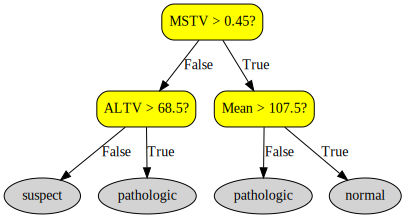

In [17]:
cls = TreeClassifier(max_depth=2)
cls.fit(Xtrain, Ytrain)
cls.draw_tree()

In [73]:
Yguess= cls.predict(Xtest)
print(accuracy_score(Ytest,Yguess))

0.8685446009389671


In the tree above, we can see that a small max_depth as 2, resulted in a pretty good testing accuracy of 87% eve though it was intended for tree drawing illustration

# TreeClassifier model max_depth hyperparameter tuning

### Tuning using the method using above (max_depth plot vs acuracy)

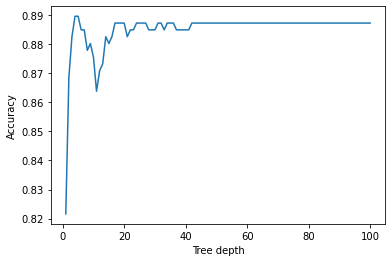

In [18]:
max_depths = np.linspace(1, 100, 100, endpoint=True)

test_results = []
for max_depth in max_depths:
    dt = TreeClassifier(max_depth=max_depth)
    dt.fit(Xtrain, Ytrain)
    Ypred = dt.predict(Xtest)
    accuracyTemp = accuracy_score(Ytest, Ypred)

    test_results.append(accuracyTemp)
line= plt.plot(max_depths, test_results, label='Test accuracy')

plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.show()

by searching the space of [1,100] max_depth we found that max_depth = 7 maximizes the accuracy of the TreeClassifier when the only used parameter is max_depth

### Tuning using sklearn gridsearch

In [76]:
dTgridTuned = TreeClassifier()
parameter_space = {'max_depth': [3,5,7,10,40,70,100],
                'criterion': ['gini','maj_sum','info_gain']}
DtTuned = GridSearchCV(dTgridTuned, parameter_space, n_jobs=-1, cv=5)
DtTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=TreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'maj_sum', 'info_gain'],
                         'max_depth': [3, 5, 7, 10, 40, 70, 100]})

In [77]:
DtTuned.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [78]:
DTFinal = TreeClassifier(max_depth=7,criterion='gini')
cross_val_score(DTFinal, Xtrain, Ytrain).mean()

0.934705882352941

by tuning the model TreeClassifier with a range of different values for max_depth and different types of splitting criterion, we found that the parameters that maximizes the classifier's accuracy are max_depth=7 and criterion = gini impurity which gives us a cross validation accuracy of 93.5% 

## TreeClassifier evaluation on the test set

In [79]:
DTFinal = TreeClassifier(max_depth=7,criterion='gini')
DTFinal.fit(Xtrain, Ytrain)
Yguess = DTFinal.predict(Xtest)
print('The testing accuracy of the TreeClassifier model is: ',round(accuracy_score(Ytest, Yguess),3))

The testing accuracy of the TreeClassifier model is:  0.913


By testing the classifier, we got a testing accuracy of 91% by using the hyperparameter <b>max_depth = 7</b> and <b>criterion = 'gini'</b>

# Task 3

In [88]:
# Read the CSV file using Pandas.
alldata = pd.read_csv('sberbank.csv')
alldata.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [90]:
# Convert the timestamp string to an integer representing the year.
def get_year(timestamp):
    return int(timestamp[:4])
alldata['year'] = alldata.timestamp.apply(get_year)

# Select the 9 input columns and the output column.
selected_columns = ['price_doc', 'year', 'full_sq', 'life_sq', 'floor', 'num_room', 'kitch_sq', 'full_all']
alldata = alldata[selected_columns]
alldata = alldata.dropna()

# Shuffle.
alldata_shuffled = alldata.sample(frac=1.0, random_state=0)

In [91]:
# Separate the input and output columns.
X = alldata_shuffled.drop('price_doc', axis=1)
# For the output, we'll use the log of the sales price.
Y = alldata_shuffled['price_doc'].apply(np.log)

# Split into training and test sets.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)

# Dummy Regressor

In [92]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
m1 = DummyRegressor()
cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.38925247260237567

By cross-validation the dummy classifier on the training data's different fold, we get a mean square error of 0.39 in predicting   the price of an apartment, given numerical information such as the number of rooms, the size of the apartment in square meters, the floor.

# Linear models

We firstly start by experimenting the Linear Regression of sklearn on our training data

### Linear Regression

In [93]:
from sklearn.metrics import mean_squared_error

In [94]:
from sklearn.linear_model import LinearRegression
ligr = LinearRegression()
cross_validate(ligr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.3013986588767175

By cross-validation the Linear Regression on the training data's different folds, we get an average mean square error of 0.301 between the different folds of the training set

### Ridge

In [95]:
from sklearn.linear_model import Ridge
rid = Ridge()
cross_validate(rid, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.3013978423217976

As we can see, the Ridge model obtained an average cross-validation mean squared error  of 0.301 between the different folds of the training set, so we proceed by tuning the Ridge model

### tuning Ridge model

In [96]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from numpy import arange

In [97]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
model = Ridge()
grid = dict()
grid['alpha'] = arange(0,50000,1000)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
RidgeTuned = search.fit(Xtrain, Ytrain)

In [98]:
print(RidgeTuned.best_score_*-1)
print(RidgeTuned.best_params_)

0.3054268311859818
{'alpha': 49000}


By tuning Ridge model with L2 penalty lamda (alpha in the code) of different values in a sequence of values of [0,1000,...,50000], we found that Rigde model with the value lambda (alpha) equal to 49000 had mean squared error of 0.3 

### Lasso

In [100]:
from sklearn.linear_model import Lasso
lasso = Lasso()
cross_validate(lasso, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.3010470671748872

In Lasso model, we also got an average (mean squared error) of 0.301 by cross validation between the different folds of the training set

#### Lasso tuning

In [101]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = arange(0, 0.1,10)
lasso = Lasso()
grid = dict()
grid['alpha'] = lasso_alphas

search = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error',cv=cv, n_jobs=-1)
lassoTuned = search.fit(Xtrain, Ytrain)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fa

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1792.6150101970438, tolerance: 0.4727181070026413
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase th

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1770.67044413759, tolerance: 0.469373372237056
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1784.6926604385797, tolerance: 0.473404131566501
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1757.7704959915093, tolerance: 0.46616186127362835
  model = cd_fast.enet_coordinate_descent(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

In [102]:
print(lassoTuned.best_score_*-1)
print(lassoTuned.best_params_)

0.3089324957581782
{'alpha': 0.0}


By tuning the model using a gridsearch, the gridsearch found that the best L1 penalty lambda (alpha) = 0 which resulted in a MSE of 0.308

# Tree regressors

### Decision Tree Regressor

In [103]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
cross_validate(dtr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.521787021857768

As we can see, the Decision Tree Regressor obtained an average cross-validation mean squared error of 0.522 between the different folds of the training data, so we proceed by tuning the Decision Tree Regressor model

### Tuning decision tree regressor

In [104]:
### Tuning using sklearn gridsearch
dTrgridTuned = DecisionTreeRegressor()
parameter_space = {'max_depth': [3,5,10,40,70,100],
                'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
                  }
DtTuned = GridSearchCV(dTrgridTuned, parameter_space, n_jobs=-1, cv=5)
DtTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    super().fit(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 351, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'squared_error'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    super().fit(
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py", line 351, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'absolute_error'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition 

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [3, 5, 10, 40, 70, 100]})

In [105]:
print(DtTuned.best_params_)
print(DtTuned.best_score_)


0.27300936515750984

By tuning the Decision tree regressor model on the parameters<b> max_depth</b> and <b> criterion</b>, we found that the hyperparameters values that minimizes the model's MSE are <b> max_depth = 5</b> and <b> creterion = 'friedman_mse'</b> which resulted in a MSE value of 0.27 

### Random Forest Regressor

In [106]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=10, random_state=0)
cross_validate(regr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1### Tuning decision tree regressor

0.2659229822429888

In the Random Forest Regressor obtained an average cross-validation mean squared error of 0.266, so we then proceed by tuning the Random Forest Regressor model

### Tuning Random Forest regressor

In [107]:
# ### Tuning using sklearn gridsearch
RfRgridTuned = RandomForestRegressor()
parameter_space = {'max_depth': [5,10,70],
                  'n_estimators' : [100,500]}
RFRTuned = GridSearchCV(RfRgridTuned, parameter_space, n_jobs=-1, cv=5)
RFRTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 70], 'n_estimators': [100, 500]})

In [108]:
print(RFRTuned.best_params_)
print(RFRTuned.best_score_)

{'max_depth': 10, 'n_estimators': 500}
0.31690611691368475


By tuning the Random forest regressor model on the parameters<b> max_depth</b> and <b>n_estimators</b> , we found that the hyperparameters values that minimizes the model's MSE are <b> max_depth = 10</b> and <b> n_estimators = 500</b> which resulted in a MSE value of 0.317 

### Gradient Boosting Regressor

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
cross_validate(gbr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

0.26453912541092567

The Gradient Boosting Regressor obtained an average cross-validation mean squared error of 0.265, so we then proceed by tuing the Gradient Boosting Regressor model

### Gradient boosting tuning

In [112]:
GBRgridTuned = GradientBoostingRegressor()
parameter_space = {
    # 'loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
    # 'n_estimators' : [ 2, 4, 8, 16, 32, 64, 100, 200,500]
                'criterion': ['mse','friedman_mse'], #'mae','squared_error',  
                  'alpha': [0.0001,0.001,0.01 ]}
GBRTuned = GridSearchCV(GBRgridTuned, parameter_space, n_jobs=-1, cv=5)
GBRTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'criterion': ['mse', 'friedman_mse']})

In [113]:
print(GBRTuned.best_params_)
print(GBRTuned.best_score_)

{'alpha': 0.001, 'criterion': 'friedman_mse'}
0.31977267920421193


By tuning the Gradient boosting on the parameters alpha and criterion, we found that the hyperparameters values that minimizes the model's MSE are 
<b>creterion = 'friedman_mse'</b> and <b>alpha = 0.001 </b>and which resulted in a MSE value of <b>0.32</b>

### MLP Regressor

In [115]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
cross_validate(mlp, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1

24.093420838771443

The MLP Regressor obtained an average cross-validation mean squared error of 24, so we then proceed by tuing the MLP model

### Tuning MLP regressor

In [116]:
mlpRgridTuned = MLPRegressor()
parameter_space = {
    'hidden_layer_sizes': [(150,),(1000,)],#,(3000,)
    'activation': ['relu','logistic'],#'tanh', 
    # 'solver': ['lbfgs', 'sgd','adam'],
    # 'alpha': [0.0001,0.001,0.01,0.1,1],
    # 'learning_rate': ['constant','invscaling', 'adaptive']
}
mlpTuned = GridSearchCV(mlpRgridTuned, parameter_space, n_jobs=-1, cv=5)
mlpTuned.fit(Xtrain, Ytrain) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'hidden_layer_sizes': [(150,), (1000,)]})

In [117]:
print(mlpTuned.best_params_)
print(mlpTuned.best_score_)

{'activation': 'logistic', 'hidden_layer_sizes': (1000,)}
0.022083778355906757


By tuning the MLP on the parameters alpha and criterion, we found that the hyperparameters values that minimizes the model's MSE are 
<b>activation = 'logistic'</b> and <b>hidden_layer_sizes = (1000,)</b>and which resulted in a MSE value of <b>0.022</b>

# Models evaluation and test set prediction

In [118]:
print("Regressors cross-validation mean squared error report: ")
print('\n')
print("Dummy Regressor:", cross_validate(m1, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1)
print('\n')
print("Decision Tree Regressor:", DtTuned.best_score_)
print('\n')
print("Random Forest Regressor:", cross_validate(regr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1)
print('\n')
print("Gradient Boosting Regressor:", cross_validate(gbr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1)
print('\n')
print("Ridge Regressor:", RidgeTuned.best_score_*-1)

print('\n')
print("Lasso Regressor:",lassoTuned.best_score_*-1)

print('\n')
print("Linear Regression:", cross_validate(ligr, Xtrain, Ytrain, scoring='neg_mean_squared_error')['test_score'].mean()*-1)

print('\n')
print("MLP Regressor:", mlpTuned.best_score_)

Regressors cross-validation mean squared error report: 


Dummy Regressor: 0.38925247260237567


Decision Tree Regressor: 0.27300936515750984


Random Forest Regressor: 0.2659229822429888


Gradient Boosting Regressor: 0.2645294893991636


Ridge Regressor: 0.3054268311859818


Lasso Regressor: 0.3089324957581782


Linear Regression: 0.3013986588767175


MLP Regressor: 0.022083778355906757


## Best performing models predictions of the test set

In [119]:
# predictions using MLP NN
# mlpTuned.fit(Xtrain,Ytrain)
Yguess = mlpTuned.predict(Xtest)
print('MLP Regressor: ')
print( 'MSE: '+str(mean_squared_error(Ytest,Yguess)))

MLP Regressor: 
MSE: 0.3978387714082671


In [120]:
# predictions using RandomForest Regressor
regr.fit(Xtrain,Ytrain)
Yguess = regr.predict(Xtest)
print('RandomForest Regressor: ')
print( 'MSE: '+str(mean_squared_error(Ytest,Yguess)))

RandomForest Regressor: 
MSE: 0.2740850405500036


In [121]:
# predictions using Gradient Boosting Regressor
gbr.fit(Xtrain,Ytrain)
Yguess = gbr.predict(Xtest)
print('Gradient Boosting Regressor: ')
print( 'MSE: '+str(mean_squared_error(Ytest,Yguess)))

Gradient Boosting Regressor: 
MSE: 0.27140993631672944


In [128]:
# predictions using DecisionTree Regressor
Yguess = DtTuned.predict(Xtest)
print('Decision Tree Regressor: ')
print( 'MSE: '+str(mean_squared_error(Ytest,Yguess)))

Decision Tree Regressor: 
MSE: 0.29083526730914583


By testing the best performing models in the cross validation phase with predicting the test set, the best performing model in predicting the testing set was the Gradient boosting regressor which predicted the testing set with a mean squared error of approximately 0.27 with a difference of +0.01 in the MSE than its cross-validation accuracy, the model was tuned using  gridsearch to find that the hyperparameters that minimizes the mse are <b>alpha= 0.001 and criterion = 'friedman_mse' </b>.

# Task 4

## Step 1

In [24]:
class DecisionTreeLeaf:

    def __init__(self, value):
        self.value = value

    # This method computes the prediction for this leaf node. This will just return a constant value.
    def predict(self, x):
        return self.value

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_id = str(node_counter)
        val_str = f'{self.value:.4g}' if isinstance(self.value, float) else str(self.value)
        graph.node(node_id, val_str, style='filled')
        return node_counter+1, node_id
        
    def __eq__(self, other):
        if isinstance(other, DecisionTreeLeaf):
            return self.value == other.value
        else:
            return False

In [25]:
class DecisionTreeBranch:

    def __init__(self, feature, threshold, low_subtree, high_subtree):
        self.feature = feature
        self.threshold = threshold
        self.low_subtree = low_subtree
        self.high_subtree = high_subtree

    # For a branch node, we compute the prediction by first considering the feature, and then 
    # calling the upper or lower subtree, depending on whether the feature is or isn't greater
    # than the threshold.
    def predict(self, x):
        if x[self.feature] <= self.threshold:
            return self.low_subtree.predict(x)
        else:
            return self.high_subtree.predict(x)

    # Utility function to draw a tree visually using graphviz.
    def draw_tree(self, graph, node_counter, names):
        node_counter, low_id = self.low_subtree.draw_tree(graph, node_counter, names)
        node_counter, high_id = self.high_subtree.draw_tree(graph, node_counter, names)
        node_id = str(node_counter)
        fname = f'F{self.feature}' if names is None else names[self.feature]
        lbl = f'{fname} > {self.threshold:.4g}?'
        graph.node(node_id, lbl, shape='box', fillcolor='yellow', style='filled, rounded')
        graph.edge(node_id, low_id, 'False')
        graph.edge(node_id, high_id, 'True')
        return node_counter+1, node_id
        

In [26]:
from graphviz import Digraph
from sklearn.base import BaseEstimator, RegressorMixin
from abc import ABC, abstractmethod

class DecisionTree(ABC, BaseEstimator):

    def __init__(self, max_depth):
        super().__init__()
        self.max_depth = max_depth
        
    # As usual in scikit-learn, the training method is called *fit*. We first process the dataset so that
    # we're sure that it's represented as a NumPy matrix. Then we call the recursive tree-building method
    # called make_tree (see below).
    def fit(self, X, Y):
        if isinstance(X, pd.DataFrame):
            self.names = X.columns
            X = X.to_numpy()
        elif isinstance(X, list):
            self.names = None
            X = np.array(X)
        else:
            self.names = None
        Y = np.array(Y)        
        self.root = self.make_tree(X, Y, self.max_depth)
        
    def draw_tree(self):
        graph = Digraph()
        self.root.draw_tree(graph, 0, self.names)
        return graph
    
    # By scikit-learn convention, the method *predict* computes the classification or regression output
    # for a set of instances.
    # To implement it, we call a separate method that carries out the prediction for one instance.
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        return [self.predict_one(x) for x in X]

    # Predicting the output for one instance.
    def predict_one(self, x):
        return self.root.predict(x)        

    # This is the recursive training 
    def make_tree(self, X, Y, max_depth):

        # We start by computing the default value that will be used if we'll return a leaf node.
        # For classifiers, this will be the most common value in Y.
        default_value = self.get_default_value(Y)

        # First the two base cases in the recursion: is the training set completely
        # homogeneous, or have we reached the maximum depth? Then we need to return a leaf.

        # If we have reached the maximum depth, return a leaf with the majority value.
        if max_depth == 0:
            return DecisionTreeLeaf(default_value)

        # If all the instances in the remaining training set have the same output value,
        # return a leaf with this value.
        if self.is_homogeneous(Y):
            return DecisionTreeLeaf(default_value)

        # Select the "most useful" feature and split threshold. To rank the "usefulness" of features,
        # we use one of the classification or regression criteria.
        # For each feature, we call best_split (defined in a subclass). We then maximize over the features.
        n_features = X.shape[1]
        _, best_feature, best_threshold = max(self.best_split(X, Y, feature) for feature in range(n_features))
        
        if best_feature is None:
            return DecisionTreeLeaf(default_value)

        # Split the training set into subgroups, based on whether the selected feature is greater than
        # the threshold or not
        X_low, X_high, Y_low, Y_high = self.split_by_feature(X, Y, best_feature, best_threshold)

        # Build the subtrees using a recursive call. Each subtree is associated
        # with a value of the feature.
        low_subtree = self.make_tree(X_low, Y_low, max_depth-1)
        high_subtree = self.make_tree(X_high, Y_high, max_depth-1)

        if low_subtree == high_subtree:
            return low_subtree

        # Return a decision tree branch containing the result.
        return DecisionTreeBranch(best_feature, best_threshold, low_subtree, high_subtree)
    
    # Utility method that splits the data into the "upper" and "lower" part, based on a feature
    # and a threshold.
    def split_by_feature(self, X, Y, feature, threshold):
        low = X[:,feature] <= threshold
        high = ~low
        return X[low], X[high], Y[low], Y[high]
    
    # The following three methods need to be implemented by the classification and regression subclasses.
    
    @abstractmethod
    def get_default_value(self, Y):
        pass

    @abstractmethod
    def is_homogeneous(self, Y):
        pass

    @abstractmethod
    def best_split(self, X, Y, feature):
        pass

In [27]:
from collections import Counter

class TreeRegressor(DecisionTree, RegressorMixin):

    def __init__(self, max_depth=10, threshold = 0.2,  criterion='var_red'):
        super().__init__(max_depth)
        self.criterion = criterion
        self.threshold = threshold
        
        
    def fit(self, X, Y):
        # For decision tree classifiers, there are some different ways to measure
        # the homogeneity of subsets.
        if self.criterion == 'var_red':
            self.criterion_function = variance_reduction_scorer
        else:
            raise Exception(f'Unknown criterion: {self.criterion}')
        super().fit(X, Y)
        self.classes_ = sorted(set(Y))

    # Select a default value that is going to be used if we decide to make a leaf.
    # We will select the most common value.
    def get_default_value(self, Y):
        return np.mean(Y)
    
    # Checks whether a set of output values is homogeneous. In the classification case, 
    # this means that all output values are identical.
    # We assume that we called get_default_value just before, so that we can access
    # the class_distribution attribute. If the class distribution contains just one item,
    # this means that the set is homogeneous.
    def is_homogeneous(self, Y):
        return np.var(Y) <= self.threshold #threshold (set to be 0.2 through trial and error to minimize the mse)
        
    # Finds the best splitting point for a given feature. We'll keep frequency tables (Counters)
    # for the upper and lower parts, and then compute the impurity criterion using these tables.
    # In the end, we return a triple consisting of
    # - the best score we found, according to the criterion we're using
    # - the id of the feature
    # - the threshold for the best split
    def best_split(self, X, Y, feature):

        # Create a list of input-output pairs, where we have sorted
        # in ascending order by the input feature we're considering.
        sorted_indices = np.argsort(X[:, feature])        
        X_sorted = list(X[sorted_indices, feature])
        Y_sorted = list(Y[sorted_indices])

        n = len(Y)
        
        
        # declaring the 2 subsets of the feature as empty list and the full list before entering the loop
        low_distr = []
        high_distr = Y_sorted
        
        # Keep track of the best result we've seen so far.
        max_score = -np.inf
        max_i = None



        # Go through all the positions (excluding the last position).
        for i in range(0, n-1):

            # Input and output at the current position.
            x_i = X_sorted[i]
            y_i = Y_sorted[i]

            
            # Update the frequency tables.
#             low_distr[y_i] += 1
#             high_distr[y_i] -= 1
            
            #low_distr subset is the output variable items before the current instance, and 
            #high_distr subset is the output variable items from and after the current instance, and 
            low_distr =  Y_sorted[0:i]    
            high_distr = Y_sorted[i:]

            # If the input is equal to the input at the next position, we will
            # not consider a split here.
            #x_next = XY[i+1][0]
            x_next = X_sorted[i+1]
            if x_i == x_next:
                continue
                

            # Compute the homogeneity criterion for a split at this position.
            score = self.criterion_function(i+1, low_distr, n-i-1, high_distr)

            # If this is the best split, remember it.
            if score > max_score:
                max_score = score
                max_i = i

        # If we didn't find any split (meaning that all inputs are identical), return
        # a dummy value.
        if max_i is None:
            return -np.inf, None, None

        # Otherwise, return the best split we found and its score.
        split_point = 0.5*(X_sorted[max_i] + X_sorted[max_i+1])
        return max_score, feature, split_point


In [28]:
def variance_reduction_scorer(n_low, low_distr, n_high, high_distr): 
    return np.var(low_distr + high_distr)-n_low/(n_low+n_high)*np.var(high_distr)-n_high/(n_low+n_high)*np.var(low_distr)

def majority_sum_scorer(n_low, low_distr, n_high, high_distr):
    maj_sum_low = low_distr.most_common(1)[0][1]
    maj_sum_high = high_distr.most_common(1)[0][1]
    return maj_sum_low + maj_sum_high
    
def entropy(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return -sum(p*np.log2(p) if p > 0 else 0 for p in ps)

def info_gain_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*entropy(low_distr)+n_high*entropy(high_distr))/(n_low+n_high)

def gini_impurity(distr):
    n = sum(distr.values())
    ps = [n_i/n for n_i in distr.values()]
    return 1-sum(p**2 for p in ps)
    
def gini_scorer(n_low, low_distr, n_high, high_distr):
    return -(n_low*gini_impurity(low_distr)+n_high*gini_impurity(high_distr))/(n_low+n_high)

1. To define the threshold, instead of setting it to a constant value that might not maximize the model's accuracy, we added a new parameter <b> threshold</b> to the init function of the model with a default value threshold = 0.2, so we can add it to the gridsearch later on, so we can get the best threshold for the homogenity of the set by the variance

2. To select a default value that is going to be used if we decide to make a leaf, we select the mean value of the output variable

3. The split that leads to the highest homogenity is selected by calculating the variance reduction function of the 2 subsets of the output variable at each observation and taking the split with the highest homogenity score, to do that, we declared the function <i>variance_reduction_scorer(n_low, low_distr, n_high, high_distr)</i>

In [29]:
dtr = TreeRegressor(max_depth=5)
dtr.fit(Xtrain, Ytrain)

In [30]:
Yguess = dtr.predict(Xtest)

In [31]:
from sklearn.metrics import mean_squared_error
  
mean_squared_error(Ytest,Yguess)

0.4027607081960747

we then use the class Tree Regressor to predict the testing set, and we get a mean squared error of 0.4 on the test set

## Tuning TressRegressor hyperparameters with gridsearch

In [119]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from numpy import arange

In [120]:
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define grid
# model = TreeRegressor()
# grid = dict()
# grid['max_depth'] = [6,12]
# grid['threshold'] = [0.1,0.2,0.3]

# # define search
# search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# # perform the search
# results = search.fit(Xtrain, Ytrain)

In [121]:
# results.best_params_
# results.best_score_

### TreeRegressorer model max_depth hyperparameter tuning

### Tuning using the method using above (max_depth plot vs acuracy)

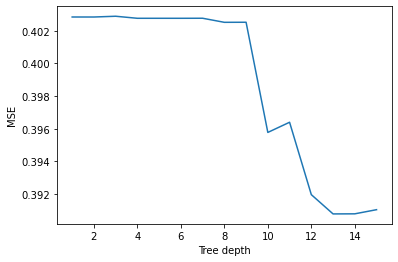

In [136]:
max_depths = np.linspace(1, 15, 15, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = TreeRegressor(max_depth=max_depth)
    dt.fit(Xtrain, Ytrain)
    Ypred = dt.predict(Xtest)
    mseTemp = mean_squared_error(Ytest, Ypred)
    test_results.append(mseTemp)
    
plt.plot(max_depths, test_results)
plt.ylabel('MSE')
plt.xlabel('Tree depth')
plt.show()

By tuning the class TreeRegressor through a graph, we get that the max_depth accuracy that minimizes the mse is max_depth = 13

## Step 2

In [37]:
def make_some_data(n):
    x = np.random.uniform(-5, 5, size=n)
    Y = (x > 1) + 0.1*np.random.normal(size=n)
    X = x.reshape(n, 1) # X needs to be a 2-dimensional matrix
    return X, Y

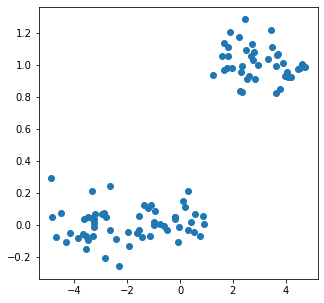

In [38]:
dataTemp = make_some_data(100)

plt.figure(figsize=(5,5))
plt.scatter(dataTemp[0], dataTemp[1], cmap='tab10');

We generate a 100 data point randomly using the data generation function

from the plot above, the data looks that it can be best described through a decision tree classifier as the data is very well splitted into two groups in the 2D space, a decision tree classifier can  classify the data points into 2 classes

In [39]:
dataTemp = make_some_data(1000)
XtrainTemp, XtestTemp, YtrainTemp, YtestTemp = train_test_split(dataTemp[0], dataTemp[1], test_size=0.2, random_state=0)

In [40]:
dtrTemp = TreeRegressor(max_depth=5)
dtrTemp.fit(XtrainTemp, YtrainTemp)

In [41]:
Yguess = dtrTemp.predict(Xtest)

In [42]:
from sklearn.metrics import mean_squared_error
  
mean_squared_error(Ytest,Yguess)

233.36671166198124

By training and testing the TreeRegressor class on the data above after splitting it into test and train data, we get a mean square error of 233 on the testing set when the max_depth is set to 5

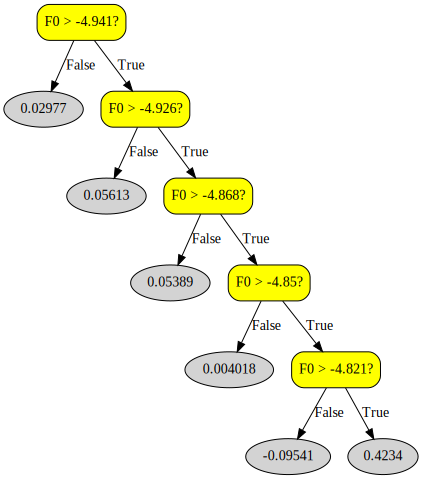

In [43]:
dtrTemp.draw_tree()

After drawing the tree, we can see that the result doesn' make sense as the root node started by value = -4.926 and the data was generated on an inteval on [-5,5], so a max_depth 5 as shown in the graph doesn't predict well the values of the data due to the severe deviation of the data values and a small depth such as 5 can't capture all the data points and predict them correctly.

## Step 3

In [44]:
dtr = TreeRegressor(max_depth=5)
dtr.fit(Xtrain, Ytrain)

In [45]:
Yguess = dtr.predict(Xtest)

In [46]:
mean_squared_error(Ytest,Yguess)

0.4027607081960747

The TreeRegressor class predicted the price of the apartments with a mean squared error of 0.4 on the testing set with <b>max_depth hyperparameter set to 5</b>

## Step 4

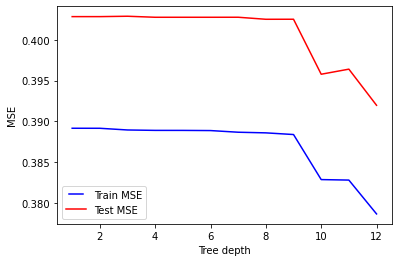

In [134]:
max_depths = np.linspace(1, 12, 12, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = TreeRegressor(max_depth=max_depth)
    dt.fit(Xtrain, Ytrain)
    YpredTrain = dt.predict(Xtrain)
    mseTrain = mean_squared_error(Ytrain, YpredTrain)
    Ypredtest = dt.predict(Xtest)
    mseTest = mean_squared_error(Ytest, Ypredtest)
    train_results.append(mseTrain)
    test_results.append(mseTest)

    
line1, = plt.plot(max_depths,train_results, 'b', label="Train MSE")
line2, = plt.plot(max_depths,test_results, 'r', label="Test MSE")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE')
plt.xlabel('Tree depth')
plt.show()

From the graph above, we can see that when the model is used to predict the training data that it was trained on, it achieved a minimum MSE of 0.38 at tree_depth = 12 (the blue line), while it achieved a testing MSE of 0.395 at tree_depth = 12 when the model is used to predict an unseen testing data (the red line), so we can conclude from the graph above that since the trends of both curves are almost the same when increasing and decreasing the tree_depth while maintaining almost a constant very low difference in the MSE between the training and testing curves, that the model is not overfitting and it predicted the unseen testing data with a proper efficiency compared to its efficiency in predicting the previously seen training data